## **Abstract**

In this workshop, we’ll embark on a data-driven journey through Mole National Park. The workshop is suited for intermediate or advanced users who have (basic) skills in Python, image processing and time series . You will learn how to perform temporal analysis of the Normalized Difference Vegetation Index (NDVI) using deep learning and satellite data. We will start with a concise introduction to remote sensing. Then, we will cover the basics of Earth Engine data types and how to analyze, and export Earth Engine NDVI data in a Jupyter environment using geemap and Google Earth Engine.Afterwards we’ll start utilizing Google Earth Engine for collecting historical NDVI values from satellite images, analyzing NDVI trends, and forecasting future NDVI patterns.

## **Terms**
-  **Remote Sensing** -> process of acquiring information about an object without coming into direct contact with it
-  **Normalized Difference Vegetation Index** -> metric for quantifying the health and density of vegetation using sensor data.
-  **Earth Engine** -> Google Earth Engine is a cloud-based platform for geospatial analysis and data visualizations
-  **geemap** -> Python package for interactive geospatial analysis and visualization with Google Earth Engine

## **Prerequisites**

To use geemap and the Earth Engine Python API, you must [register](https://colab.research.google.com/corgiredirector?site=https%3A%2F%2Fcode.earthengine.google.com%2Fregister) for an Earth Engine account and follow the instructions [here](https://colab.research.google.com/corgiredirector?site=https%3A%2F%2Fdocs.google.com%2Fdocument%2Fd%2F1ZGSmrNm6_baqd8CHt33kIBWOlvkh-HLr46bODgJN1h0%2Fedit%3Fusp%3Dsharing) to create a Cloud Project. Earth Engine is free for noncommercial and research use.

### **Install/upgrade  packages**


The geemap package is pre-installed in Google Colab and is updated to the latest minor or major release every few weeks.



In [ ]:
!pip install geemap

### **Local Installation**

Note that some geemap features do not work properly with Google Colab. If you are familiar with Anaconda or Miniconda, it is recommended to create a new conda environment to install geemap and its optional dependencies on your local computer.



```
conda create -n gee python=3.11
conda activate gee
conda install -c conda-forge mamba
mamba install -c conda-forge geemap pygis
#mamba install -c conda-forge jupyterlab
```



### **Import libraries**

In [29]:
import geemap
import ee
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### **Authenticate and Initialize Earth Engine**

We need to authenticate Earth Engine before using it. The package for the Earth Engine Python API is called earthengine-api, which should have been automatically installed by the geemap package

In [87]:
# Authenticate to the Earth Engine servers
ee.Authenticate()

# Initialize the Earth Engine API
ee.Initialize(project="omdena-botswana")

## **Initialize/create interactive map**

Interactive maps use the ipyleaflet plotting backend. The `geemap.Map` class inherits the `ipyleaflet.Map` class. Therefore, you can use the same syntax to create an interactive map as you would with [ipyleaflet.Map](https://ipyleaflet.readthedocs.io/en/latest/map_and_basemaps/map.html). Let's create an interactive map

In [88]:
m = geemap.Map()
m

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

The world map is huge, you may want to center to a specific place, the geemap provide for that with arguments like `center` `([lat, lon])`, `zoom`, `width`, and `height`

In [89]:
m = geemap.Map(center=[-22, 17], zoom=6, height=600)
m

Map(center=[-22, 17], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(chi…

In [90]:
m.center

[-22, 17]

In [91]:
m.zoom

6.0

## Adding basemaps

There are several ways to add basemaps to a map. You can specify the basemap to use in the basemap keyword argument when creating the map. Alternatively, you can add basemap layers to the map using the add_basemap method. Geemap has hundreds of built-in basemaps available that can be easily added to the map with only one line of code.

In [ ]:
m = geemap.Map(basemap="Esri.WorldImagery")
m

You can add as many basemaps as you like to the map. For example, the following code adds the OpenTopoMap basemap to the map above:

In [ ]:
m.add_basemap("Esri.WorldTopoMap")

In [ ]:
m.add_basemap("OpenTopoMap")

## **Earth Engine Data Types**
The Earth Engine API is composed of objects and methods. Objects represent data types such as raster images, vector features, numbers, and strings

**Google Earth Engine data types**
- **Image**: the fundamental raster data type in Earth Engine.
- **ImageCollection**: a stack or time-series of images.
- **Geometry**: the fundamental vector data type in Earth Engine.
- **Feature**: a Geometry with attributes.
- **FeatureCollection**: a set of features.


### Loading Earth Engine images

In [132]:
image = ee.Image("USGS/SRTMGL1_003")
image

### Visualizing Earth Engine images


In [133]:
Map = geemap.Map(center=[21.79, 70.87], zoom=3)
image = ee.Image("USGS/SRTMGL1_003")
vis_params = {
    "min": 0,
    "max": 6000,
    "palette": ["006633", "E5FFCC", "662A00", "D8D8D8", "F5F5F5"],
}
Map.addLayer(image, vis_params, "SRTM")
Map

Map(center=[21.79, 70.87], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGU…

### Visualizing image collections

To visualize an Earth Engine ImageCollection, we need to convert an ImageCollection to an Image by compositing all the images in the collection to a single image representing, for example, the min, max, median, mean or standard deviation of the images. For example, to create a median value image from a collection, use the collection.median() method. Let's create a median image from the Sentinel-2 surface reflectance collection

In [134]:
Map = geemap.Map()
collection = ee.ImageCollection("COPERNICUS/S2_SR")
image = collection.median()

vis = {
    "min": 0.0,
    "max": 3000,
    "bands": ["B4", "B3", "B2"],
}

Map.setCenter(83.277, 17.7009, 12)
Map.addLayer(image, vis, "Sentinel-2")
Map

Map(center=[17.7009, 83.277], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDat…

### Filtering image collections

In [135]:
Map = geemap.Map()
collection = (
    ee.ImageCollection("COPERNICUS/S2_SR")
    .filterDate("2021-01-01", "2022-01-01")
    .filter(ee.Filter.lt("CLOUDY_PIXEL_PERCENTAGE", 5))
)
image = collection.median()

vis = {
    "min": 0.0,
    "max": 3000,
    "bands": ["B4", "B3", "B2"],
}

Map.setCenter(83.277, 17.7009, 12)
Map.addLayer(image, vis, "Sentinel-2")
Map

Map(center=[17.7009, 83.277], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDat…

### FeatureCollection

### Loading feature collections

The Earth Engine Data Catalog hosts a variety of vector datasets  (country boundaries, and more) as feature collections.

In [139]:
ghana = ee.FeatureCollection("FAO/GAUL/2015/level2") \
            .filter(ee.Filter.eq('ADM0_NAME', 'Ghana'))
Map = geemap.Map(center=[21.79, 70.87], zoom=3)
Map.addLayer(ghana)
Map


Map(center=[21.79, 70.87], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGU…

## **Earth Engine Data Catalog**
The [Earth Engine Data Catalog](https://developers.google.com/earth-engine/datasets) hosts a variety of geospatial datasets. As of May 2024, the catalog contains over 1,000 datasets with a total size of over 80 petabytes. Some notable datasets include: Landsat, Sentinel, MODIS, NAIP, etc. For a complete list of datasets in CSV or JSON formats, see the Earth Engine Datasets List.

# **Data Collection**

### **Define Region of Interest**

Our region of interest is **Mole National Park**. We will use World Conservation Monitoring Centre /World Database on Protected Areas (WDPA) polygons feature collection, which is typically used for defining protected areas like national parks. The WCMC (World Conservation Monitoring Centre) and WDPA (World Database on Protected Areas) provide geographic data about global protected areas.

**Quick Facts about Mole National Park**
-  4,577 km2 of fairly undisturbed Guinea savannah in the northern part of Ghana.
-   742 vascular plant species
-   90 mammal species including 5 primatespecies
-   334 bird species
-   33 reptiles
-   9 amphibian species, and
-   some 120 butterfly species

In [93]:
aoi = ee.FeatureCollection('WCMC/WDPA/current/polygons').filter(
    ee.Filter.eq('NAME', 'Mole')).geometry()

m = geemap.Map(center=[9.91474384324173, -1.4117431640625002], zoom=8)
m.addLayer(aoi)
m



Map(center=[9.91474384324173, -1.4117431640625002], controls=(WidgetControl(options=['position', 'transparent_…

**National Park From Above** 

Views from above, that is satelite images of the park

In [94]:
timelapse = geemap.modis_ndvi_timelapse(
    aoi,
    out_gif="ndvi.gif",
    data="Terra",
    band="NDVI",
    start_date="2000-01-01",
    end_date="2024-08-30",
    frames_per_second=3,
    title="MODIS NDVI Timelapse",
    overlay_data="countries",
)
geemap.show_image(timelapse)

Generating URL...
Please wait ...
The GIF image has been saved to: C:\Users\HP\PyCon_Africa\ndvi.gif


Output()

## **NDVI Collection**

Let us collect the now collect the NDVI time series data.

**Moderate Resolution Imaging Spectroradiometer (MODIS)** vegetation indices are designed to provide consistent spatial and temporal comparisons of vegetation conditions. Blue, red, and near-infrared reflectances

In this cell, we're defining a helper function that will allow us to calculate statistics (like the average) for a specific area over time, using satellite imagery. This is a common task when working with Earth observation data, especially if we want to analyze how a certain region changes

In [146]:
def create_reduce_region_function(geometry,
                                  reducer=ee.Reducer.mean(),
                                  scale=1000,
                                  crs='EPSG:4326',
                                  bestEffort=True,
                                  maxPixels=1e13,
                                  tileScale=4):
  """Creates a region reduction function.

  Creates a region reduction function intended to be used as the input function
  to ee.ImageCollection.map() for reducing pixels intersecting a provided region
  to a statistic for each image in a collection. See ee.Image.reduceRegion()
  documentation for more details.

  Args:
    geometry:
      An ee.Geometry that defines the region over which to reduce data.
    reducer:
      Optional; An ee.Reducer that defines the reduction method.
    scale:
      Optional; A number that defines the nominal scale in meters of the
      projection to work in.
    crs:
      Optional; An ee.Projection or EPSG string ('EPSG:5070') that defines
      the projection to work in.
    bestEffort:
      Optional; A Boolean indicator for whether to use a larger scale if the
      geometry contains too many pixels at the given scale for the operation
      to succeed.
    maxPixels:
      Optional; A number specifying the maximum number of pixels to reduce.
    tileScale:
      Optional; A number representing the scaling factor used to reduce
      aggregation tile size; using a larger tileScale (e.g. 2 or 4) may enable
      computations that run out of memory with the default.

  Returns:
    A function that accepts an ee.Image and reduces it by region, according to
    the provided arguments.
  """

  def reduce_region_function(img):
    """Applies the ee.Image.reduceRegion() method.

    Args:
      img:
        An ee.Image to reduce to a statistic by region.

    Returns:
      An ee.Feature that contains properties representing the image region
      reduction results per band and the image timestamp formatted as
      milliseconds from Unix epoch (included to enable time series plotting).
    """

    stat = img.reduceRegion(
        reducer=reducer,
        geometry=geometry,
        scale=scale,
        crs=crs,
        bestEffort=bestEffort,
        maxPixels=maxPixels,
        tileScale=tileScale)

    return ee.Feature(geometry, stat).set({'millis': img.date().millis()})
  return reduce_region_function

## Formating

This function, fc_to_dict(fc), allows us to easily extract and summarize the properties of all features in a feature collection as a dictionary. Each feature in Earth Engine can have multiple attributes, such as NDVI values, timestamps, or geographic information. By using this function, we can convert the feature collection's properties into a dictionary format, where each key is a property name and the corresponding value is a list of values for all features in the collection. This makes it easier to work with and analyze the data for further processing.

In [147]:
def fc_to_dict(fc):
    """
    Converts the properties of a feature collection to a dictionary.

    This function extracts the property names and their corresponding values 
    for all features within a given Earth Engine feature collection and 
    returns them in the form of a dictionary.

    Args:
        fc: An ee.FeatureCollection containing multiple features, each with 
            properties (attributes).

    Returns:
        ee.Dictionary: A dictionary where keys are property names, and values 
        are lists of property values for all features in the collection.
    """
    # Get property names from the first feature in the collection.
    prop_names = fc.first().propertyNames()

    # Extract property values for all features in the collection.
    prop_lists = fc.reduceColumns(
        reducer=ee.Reducer.toList().repeat(prop_names.size()),
        selectors=prop_names).get('list')

    # Create a dictionary from the property names and corresponding values.
    return ee.Dictionary.fromLists(prop_names, prop_lists)


## Add date columns

This function, add_date_info(df), is designed to help us convert timestamp data (in milliseconds) into a readable date format. When working with time-series data, it’s useful to break down the timestamp into more specific date components like year, month, day, and day of the year (DOY) for easier analysis and visualization

In [148]:
def add_date_info(df):
    """
    Adds date-related variables to a DataFrame.

    This function converts a 'millis' column (which contains timestamps in 
    milliseconds) into a human-readable datetime format and then extracts 
    additional date information such as year, month, day, and day of the year 
    (DOY) into separate columns.

    Args:
        df: A pandas DataFrame that contains a column named 'millis', which 
            stores timestamps in milliseconds.

    Returns:
        pandas.DataFrame: The modified DataFrame with new columns for 
        'Timestamp', 'Year', 'Month', 'Day', and 'DOY' (Day of the Year).
    """
    # Convert 'millis' column from milliseconds to a datetime format.
    df['Timestamp'] = pd.to_datetime(df['millis'], unit='ms')

    # Extract year, month, day, and day of the year (DOY) from 'Timestamp'.
    df['Year'] = pd.DatetimeIndex(df['Timestamp']).year
    df['Month'] = pd.DatetimeIndex(df['Timestamp']).month
    df['Day'] = pd.DatetimeIndex(df['Timestamp']).day
    df['DOY'] = pd.DatetimeIndex(df['Timestamp']).dayofyear

    return df

In [149]:
# Define MODIS NDVI collection
#modis_ndvi_collection = ee.ImageCollection('MODIS/006/MOD13A2') \
 #   .filterDate('2000-01-01', '2023-01-01') \
 #   .filterBounds(mole)\
  #  .select('NDVI')

## Creating a Dynamic 25-Year Date Range for Time-Series Analysis

We will create a 25-year date range that we will use for our analysis. First, we get today's date using pandas and Earth Engine's ee.Date() function. Then, we generate a date range that starts 25 years ago and ends today

In [150]:
today = ee.Date(pd.to_datetime('today'))
date_range = ee.DateRange(today.advance(-25, 'years'), today)

## Filter NDVI Data and Apply Region-Based Reduction

In this section, we are working with **MODIS satellite data** to analyze NDVI values over a specified area. First, we filter the MODIS NDVI dataset to focus on the last 25 years, then apply a function to reduce each image to its mean NDVI over the area of interest. we then create a feature collection that contains the reduced NDVI values for each image and remove any invalid or missing data.

**MODIS/006/MOD13A2** is a satellite dataset that provides vegetation indices such as the Normalized Difference Vegetation Index (NDVI) at a spatial resolution of 1 kilometer. It is part of NASA's MODIS (Moderate Resolution Imaging Spectroradiometer) mission and is used to monitor vegetation health, land cover changes, and ecological conditions. The dataset is updated every 16 days.

In [151]:
ndvi = ee.ImageCollection('MODIS/006/MOD13A2').filterDate(date_range).select('NDVI')

reduce_ndvi = create_reduce_region_function(
    geometry=aoi, reducer=ee.Reducer.mean(), scale=1000, crs='EPSG:3310')

ndvi_stat_fc = ee.FeatureCollection(ndvi.map(reduce_ndvi)).filter(
    ee.Filter.notNull(ndvi.first().bandNames()))

## Convert NDVI FeatureCollection to a Pandas DataFrame

In this step, we are converting the NDVI data into a format that we can work with in Python using pandas. First, we turn the NDVI FeatureCollection into a dictionary and then transform it into a pandas DataFrame.

In [152]:
ndvi_dict = fc_to_dict(ndvi_stat_fc).getInfo()
ndvi_df = pd.DataFrame(ndvi_dict)
display(ndvi_df)
print(ndvi_df.dtypes)

NDVI         millis system:index
0    3681.516463   950832000000   2000_02_18
1    3093.707241   952214400000   2000_03_05
2    3720.103203   953596800000   2000_03_21
3    4079.337998   954979200000   2000_04_06
4    4384.022551   956361600000   2000_04_22
..           ...            ...          ...
524  4023.118222  1670025600000   2022_12_03
525  3387.256252  1671408000000   2022_12_19
526  3175.382335  1672531200000   2023_01_01
527  3371.883076  1673913600000   2023_01_17
528  3452.552272  1675296000000   2023_02_02

[529 rows x 3 columns]

NDVI            float64
millis            int64
system:index     object
dtype: object


In [153]:
ndvi_df['NDVI'] = ndvi_df['NDVI'] / 10000
ndvi_df = add_date_info(ndvi_df)
ndvi_df.head()

NDVI        millis system:index  Timestamp  Year  Month  Day  DOY
0  0.368152  950832000000   2000_02_18 2000-02-18  2000      2   18   49
1  0.309371  952214400000   2000_03_05 2000-03-05  2000      3    5   65
2  0.372010  953596800000   2000_03_21 2000-03-21  2000      3   21   81
3  0.407934  954979200000   2000_04_06 2000-04-06  2000      4    6   97
4  0.438402  956361600000   2000_04_22 2000-04-22  2000      4   22  113

## **Data Processing**

In [154]:
ndvi_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 529 entries, 0 to 528
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   NDVI          529 non-null    float64       
 1   millis        529 non-null    int64         
 2   system:index  529 non-null    object        
 3   Timestamp     529 non-null    datetime64[ns]
 4   Year          529 non-null    int32         
 5   Month         529 non-null    int32         
 6   Day           529 non-null    int32         
 7   DOY           529 non-null    int32         
dtypes: datetime64[ns](1), float64(1), int32(4), int64(1), object(1)
memory usage: 24.9+ KB


In [155]:
#ndvi_df.to_csv("na-ndvi.csv")

In [156]:
ndvi_df.describe()

NDVI        millis                      Timestamp         Year  \
count  529.000000  5.290000e+02                            529   529.000000   
mean     0.515627  1.313174e+12  2011-08-12 18:33:20.756143616  2011.130435   
min      0.224946  9.508320e+11            2000-02-18 00:00:00  2000.000000   
25%      0.372010  1.132186e+12            2005-11-17 00:00:00  2005.000000   
50%      0.535243  1.313194e+12            2011-08-13 00:00:00  2011.000000   
75%      0.643482  1.494288e+12            2017-05-09 00:00:00  2017.000000   
max      0.768337  1.675296e+12            2023-02-02 00:00:00  2023.000000   
std      0.148014  2.097277e+11                            NaN     6.648080   

            Month         Day        DOY  
count  529.000000  529.000000  529.00000  
mean     6.336484   15.266541  177.00000  
min      1.000000    1.000000    1.00000  
25%      3.000000    8.000000   81.00000  
50%      6.000000   16.000000  177.00000  
75%      9.000000   23.000000  273.00000  
max     12.000000   31.000000  353.00000  
std      3.436134    9.052814  106.23245

### **Check for missing values**


In [157]:
print(f'There are {ndvi_df.isna().sum().sum()} missing values in the entire dataset.')

There are 0 missing values in the entire dataset.


### **Check for unique values**


In [158]:
#determine the number of unique categories in each variable
ndvi_df.nunique()

NDVI            529
millis          529
system:index    529
Timestamp       529
Year             24
Month            12
Day              29
DOY              23
dtype: int64

### **Check if there values > 1 and < -1**
-  NDVI values typically range from -1 to 1, with higher values indicating healthier and more dense vegetation. Water takes values closer to -1, green
vegetation takes values close to +1

    -  Values close to 1 indicate dense and healthy vegetation, such as forests or agricultural fields with lush green vegetation.
    -  Values around 0 indicate bare soil, rocks, or water bodies.
    -  Negative values usually represent features such as water bodies or clouds.


In [159]:
invalid_values = ndvi_df[(ndvi_df['NDVI'] > 1) | (ndvi_df['NDVI'] < -1)]

if len(invalid_values) > 0:
    print("There are invalid NDVI values:")
    print(invalid_values)
else:
    print("No invalid NDVI values found.")

No invalid NDVI values found.


## Exploratory Data Analysis (EDA)

The next step is EDA. We will do some data analysis to summarize and visualize our NDVI time series to understand their main characteristics, patterns, and relationships.

## Visualizing NDVI Distribution with a Histogram

In this section, we are visualizing the distribution of NDVI values using a histogram. The histogram will help us understand the range and distribution of vegetation health as indicated by the NDVI measurements

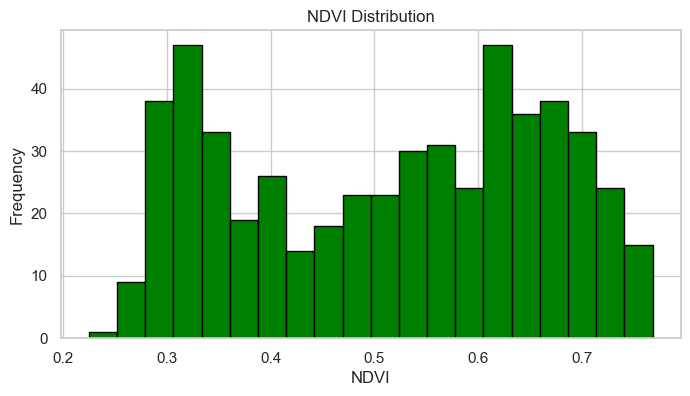

In [160]:
# Set plot style
sns.set(style="whitegrid")

# 1. NDVI Distribution (Histogram)
plt.figure(figsize=(8, 4))
plt.hist(ndvi_df['NDVI'], bins=20, color='green', edgecolor='black')
plt.title('NDVI Distribution')
plt.xlabel('NDVI')
plt.ylabel('Frequency')
plt.show()

## Analyze NDVI Trends Over Time with a Line Plot



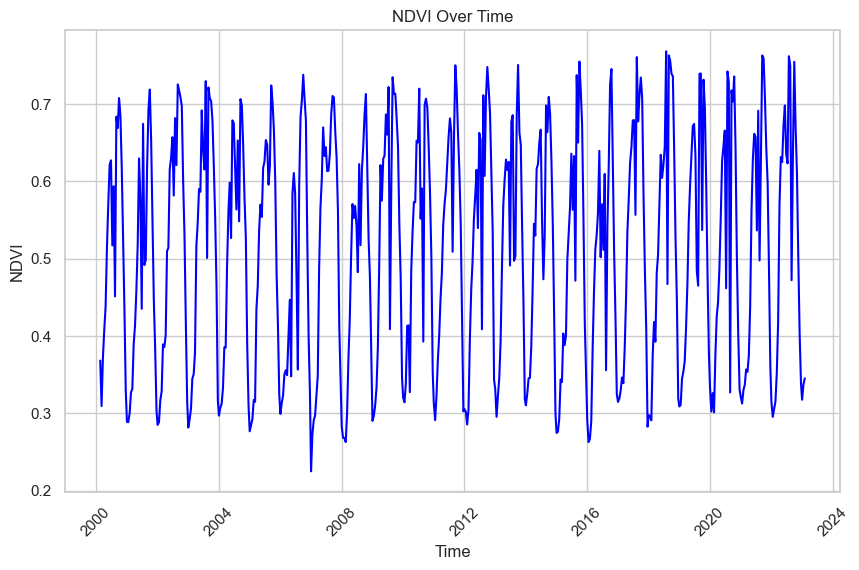

In [161]:
# 2. NDVI Over Time (Line Plot)
plt.figure(figsize=(10, 6))
plt.plot(ndvi_df['Timestamp'], ndvi_df['NDVI'], color='blue')
plt.title('NDVI Over Time')
plt.xlabel('Time')
plt.ylabel('NDVI')
plt.xticks(rotation=45)
plt.show()

## Explore Monthly NDVI Trends with Box Plots

In this section, we are examining monthly NDVI trends using a box plot. This visualization allows us to see the distribution of NDVI values for each month, helping us identify patterns and variations in vegetation health throughout the years

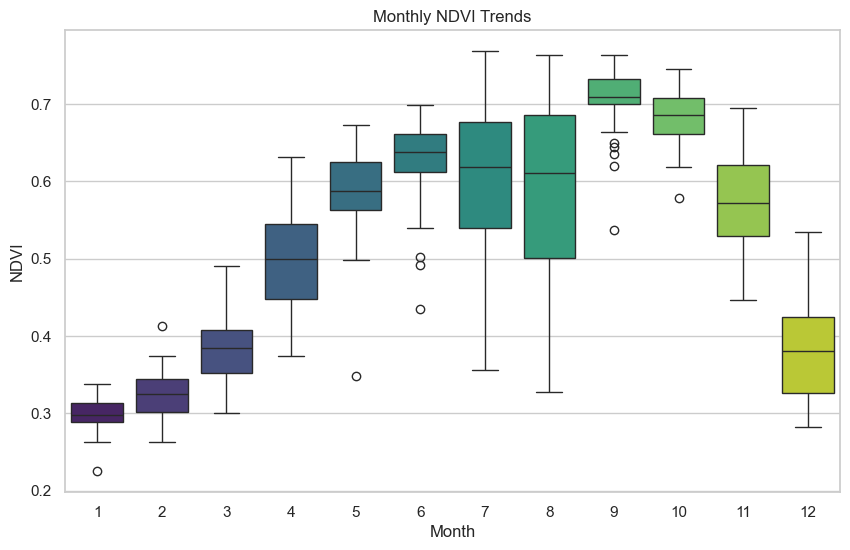

In [162]:
#Monthly NDVI Trends (Box Plot)
plt.figure(figsize=(10, 6))
sns.boxplot(x='Month', y='NDVI', data=ndvi_df, palette='viridis')
plt.title('Monthly NDVI Trends')
plt.xlabel('Month')
plt.ylabel('NDVI')
plt.show()

In [163]:
ndvi_df.head(2)

NDVI        millis system:index  Timestamp  Year  Month  Day  DOY
0  0.368152  950832000000   2000_02_18 2000-02-18  2000      2   18   49
1  0.309371  952214400000   2000_03_05 2000-03-05  2000      3    5   65

### **NDVI Time Series**

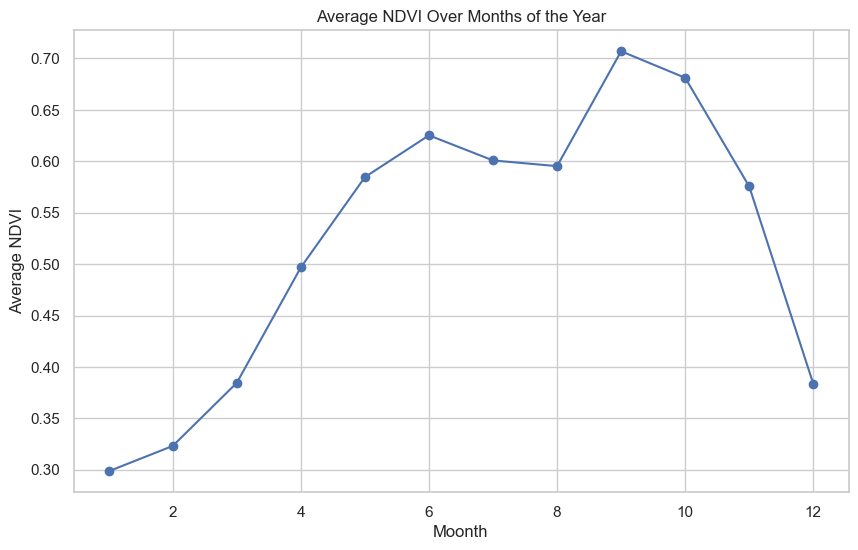

In [164]:
average_ndvi = ndvi_df.groupby('Month')['NDVI'].mean().reset_index()
average_ndvi['Month'] = average_ndvi['Month'].astype(int)
plt.figure(figsize=(10, 6))
plt.plot(average_ndvi['Month'], average_ndvi['NDVI'], marker='o', linestyle='-', color='b')
plt.xlabel('Moonth')
plt.ylabel('Average NDVI')
plt.title('Average NDVI Over Months of the Year')
plt.grid(True)
plt.show()

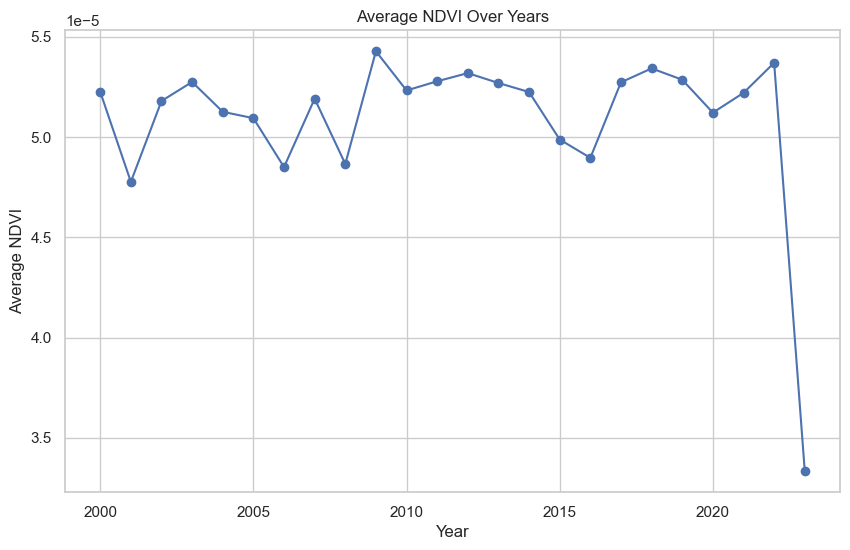

In [121]:
average_ndvi = ndvi_df.groupby('Year')['NDVI'].mean().reset_index()
average_ndvi['Year'] = average_ndvi['Year'].astype(int)
plt.figure(figsize=(10, 6))
plt.plot(average_ndvi['Year'], average_ndvi['NDVI'], marker='o', linestyle='-', color='b')
plt.xlabel('Year')
plt.ylabel('Average NDVI')
plt.title('Average NDVI Over Years')
plt.grid(True)
plt.show()

**Seasonal decomposition**

Seasonal decomposition is a statistical technique used to analyze time series data by breaking it down into several components: trend, seasonality, and residuals. This decomposition helps in understanding the underlying patterns in the data, making it easier to forecast future values. The main components are:

- **Observed**: The original time series data that contains the effects of trend, seasonality, and noise.
- **Trend**: The long-term progression of the series, indicating an increasing or decreasing pattern over time.
- **Seasonal**: The repeating fluctuations that occur at regular intervals due to seasonal effects (e.g., monthly, - quarterly, yearly).
- **Residual**: The noise or random variation in the data after removing the trend and seasonal components, representing what remains unexplained.

In [122]:
ndvi_df = ndvi_df.set_index('Timestamp')

<Figure size 1100x700 with 0 Axes>

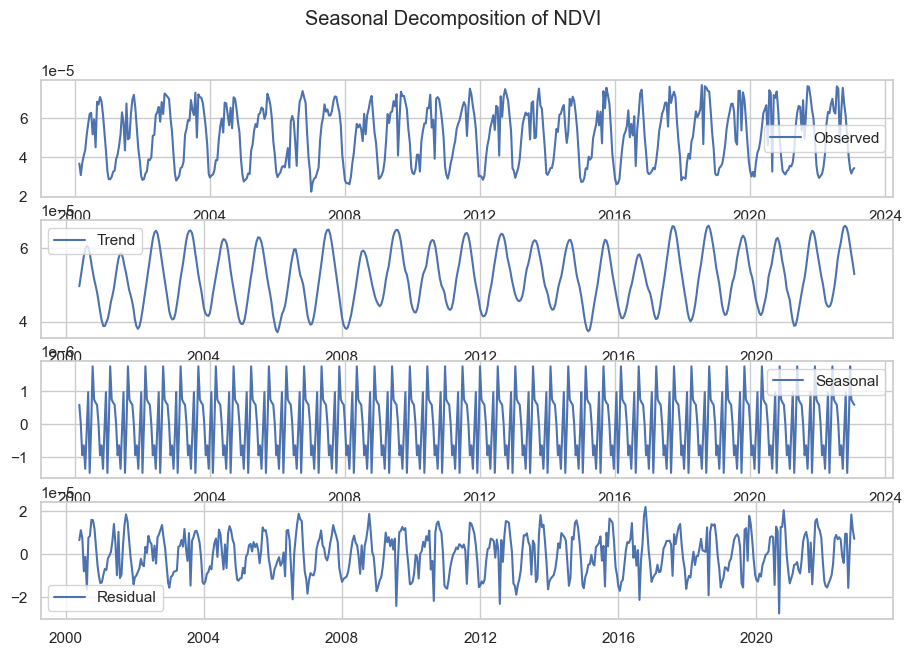

In [124]:
from statsmodels.tsa.seasonal import seasonal_decompose
#Perform seasonal decomposition
result = seasonal_decompose(ndvi_df['NDVI'], model='additive', period=12)

# Plot the components
plt.figure(figsize=(11, 7))

# Plot the components
plt.figure(figsize=(11, 7))

plt.subplot(411)
plt.plot(result.observed, label='Observed')
plt.legend()

plt.subplot(412)
plt.plot(result.trend, label='Trend')
plt.legend()

plt.subplot(413)
plt.plot(result.seasonal, label='Seasonal')
plt.legend()

plt.subplot(414)
plt.plot(result.resid, label='Residual')
plt.legend()

plt.suptitle('Seasonal Decomposition of NDVI')
plt.show()

**Forecast with Facebook Prophet**

In [167]:
ndvi_df = ndvi_df.reset_index()

In [168]:
# Rename columns for Prophet
prophet_df = ndvi_df[['Timestamp', 'NDVI']].rename(columns={'Timestamp': 'ds', 'NDVI': 'y'})
prophet_df.head()

ds         y
0 2000-02-18  0.368152
1 2000-03-05  0.309371
2 2000-03-21  0.372010
3 2000-04-06  0.407934
4 2000-04-22  0.438402

In [170]:
m = Prophet(interval_width=0.95)
model = m.fit(prophet_df)

00:02:24 - cmdstanpy - INFO - Chain [1] start processing
00:02:24 - cmdstanpy - INFO - Chain [1] done processing


In [174]:
future = m.make_future_dataframe(periods=365)
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds      yhat  yhat_lower  yhat_upper
889 2024-01-29  0.318963    0.210539    0.428512
890 2024-01-30  0.319748    0.214281    0.419041
891 2024-01-31  0.320595    0.210518    0.426793
892 2024-02-01  0.321510    0.214402    0.433576
893 2024-02-02  0.322500    0.207790    0.437566

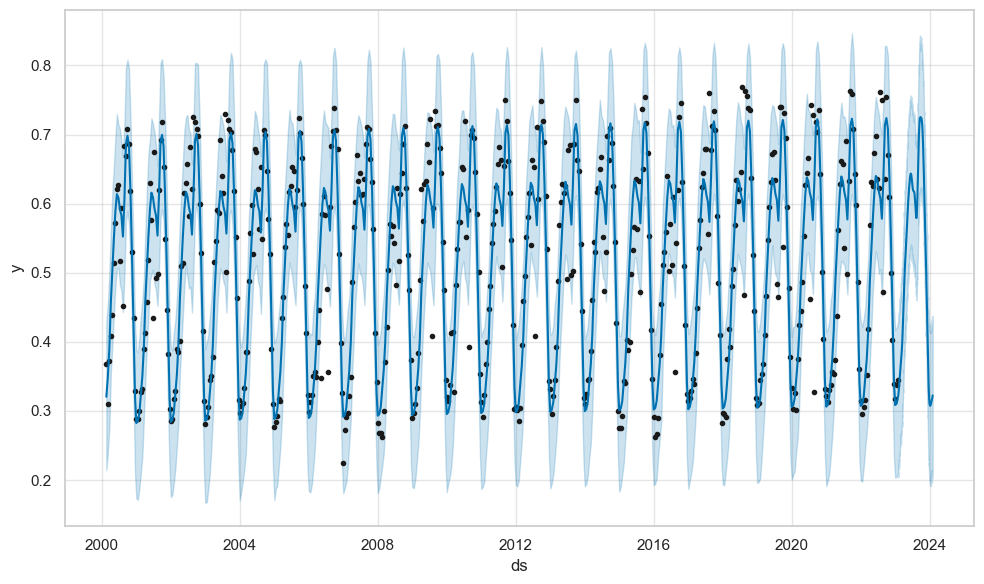

In [175]:
fig1 = m.plot(forecast)

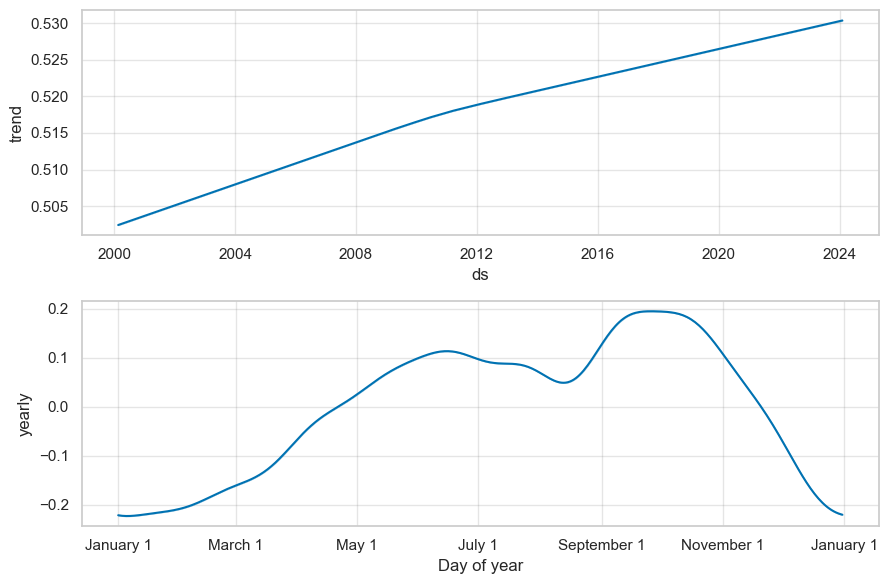

In [176]:
fig2 = m.plot_components(forecast)

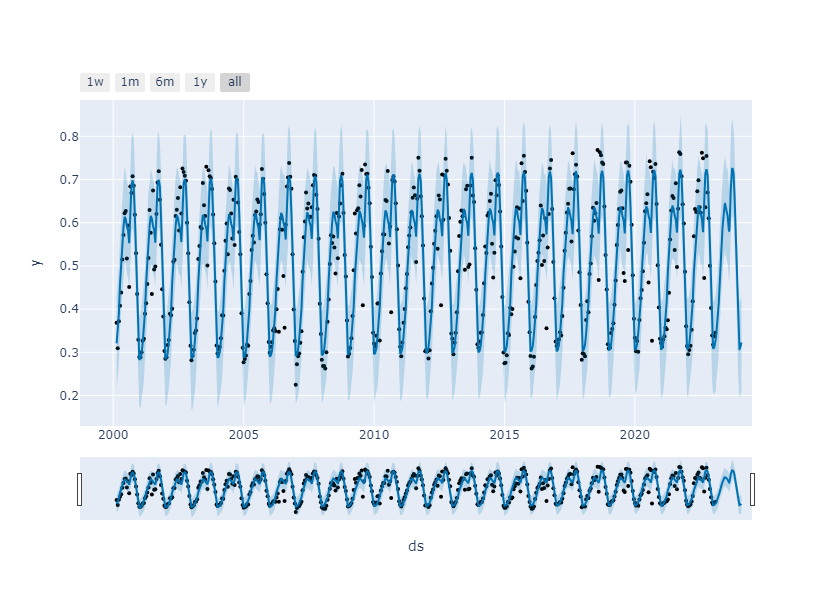

In [177]:
from prophet.plot import plot_plotly, plot_components_plotly

plot_plotly(m, forecast)